In [30]:
pip install tensorflow keras pillow matplotlib tk


Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import os

In [34]:
# Define paths
data_path = '/Users/sivaramasrk10/DFF'
healthy_path = data_path + '/Healthy'
diseased_path = data_path + '/Diseased'
augmented_data_path = '/Users/sivaramasrk10/AugmentedDFF2'  # Path to save augmented data

# Image parameters
img_size = (128, 128)
batch_size = 10
num_augmented_images = 5  # Number of augmented images per original image

# Data augmentation
datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to save augmented images
def save_augmented_images(datagen, original_data_dir, augmented_data_dir, num_augmented_images):
    if not os.path.exists(augmented_data_dir):
        os.makedirs(augmented_data_dir)

    for class_dir in os.listdir(original_data_dir):
        class_path = os.path.join(original_data_dir, class_dir)
        save_path = os.path.join(augmented_data_dir, class_dir)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        if not os.path.isdir(class_path):
            continue
        
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=save_path,
                                          save_prefix='aug', save_format='jpeg'):
                    i += 1
                    if i >= num_augmented_images:
                        break
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

# Save augmented images
save_augmented_images(datagen, data_path, augmented_data_path, num_augmented_images)


In [39]:
# Create new ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    augmented_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    augmented_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 2367 images belonging to 2 classes.
Found 591 images belonging to 2 classes.


In [41]:
len(train_generator), len(validation_generator)

(237, 60)

In [43]:
DFF = tf.keras.utils.image_dataset_from_directory('/Users/sivaramasrk10/DFF', image_size=(256, 256))


Found 645 files belonging to 2 classes.


In [45]:
DFF_iterator = DFF.as_numpy_iterator()

In [47]:
batch = DFF_iterator.next()
images, labels = batch

2024-07-23 15:00:25.688615: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


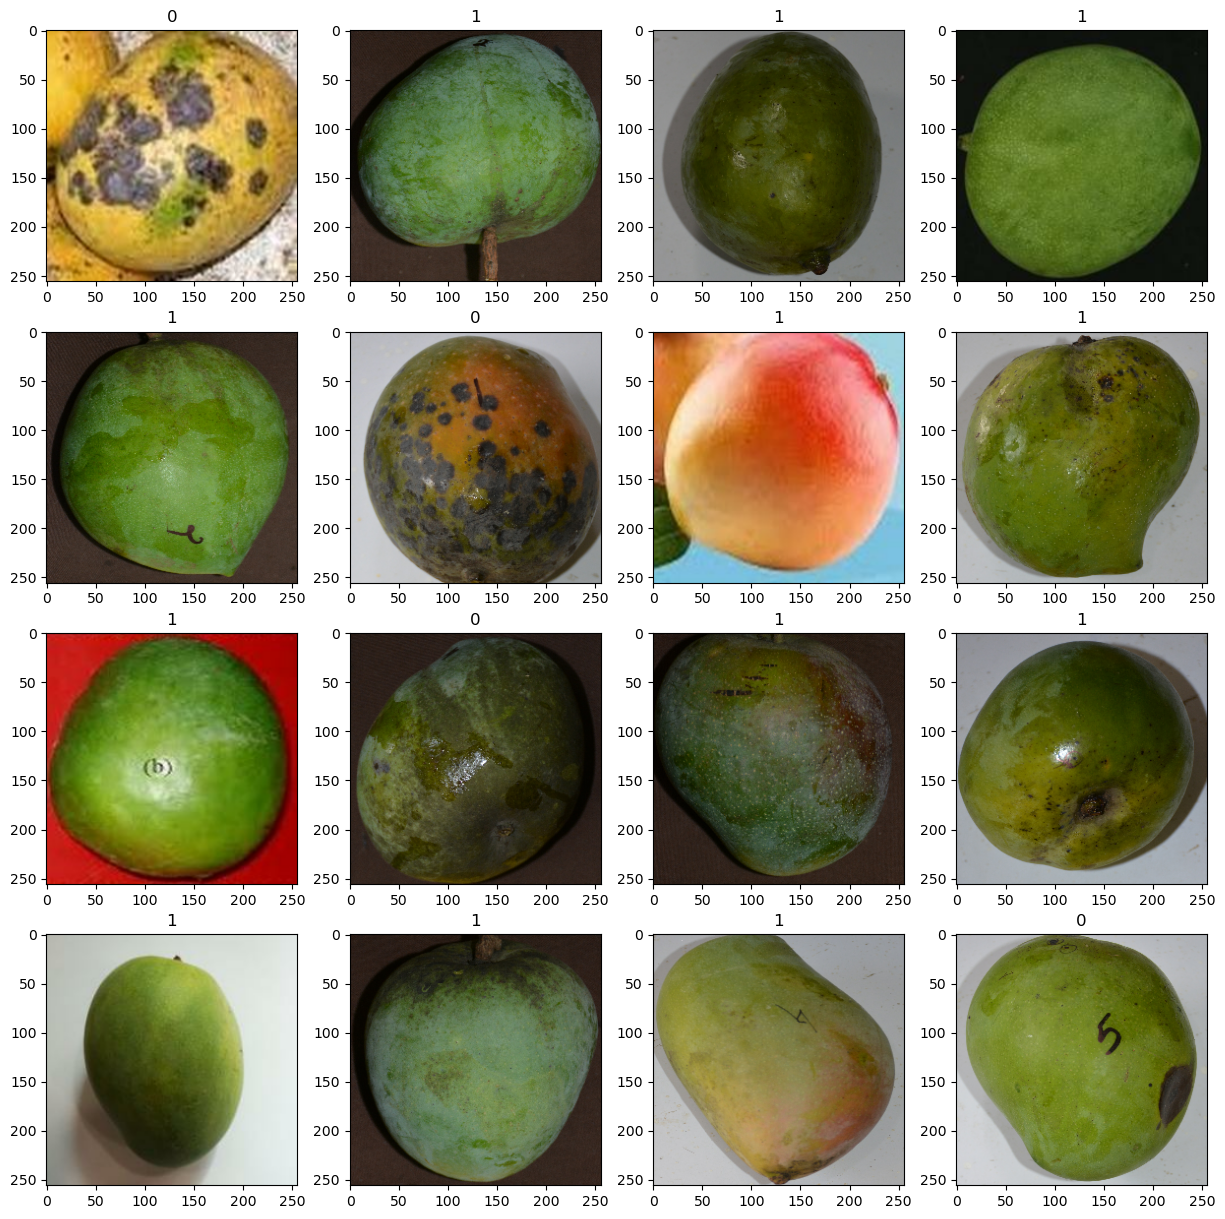

In [48]:
fig,ax = plt.subplots(nrows = 4,ncols = 4, figsize=(15,15))
for idx, img in enumerate(batch[0][:16]):
    row = idx // 4
    col = idx % 4
    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(batch[1][idx])

In [73]:
import shutil

# Create combined directory structure
combined_dir = '/Users/sivaramasrk10/CombinedDFF'
healthy_dir = os.path.join(combined_dir, 'Healthy')
diseased_dir = os.path.join(combined_dir, 'Diseased')

os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(diseased_dir, exist_ok=True)

# Define source directories
dff_healthy = '/Users/sivaramasrk10/DFF/Healthy'
dff_diseased = '/Users/sivaramasrk10/DFF/Diseased'
augmented_healthy = '/Users/sivaramasrk10/AugmentedDFF2/Healthy'
augmented_diseased = '/Users/sivaramasrk10/AugmentedDFF2/Diseased'

# Copy all Healthy images to healthy_dir
for src_dir in [dff_healthy, augmented_healthy]:
    for file_name in os.listdir(src_dir):
        full_file_name = os.path.join(src_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, healthy_dir)

# Copy all Diseased images to diseased_dir
for src_dir in [dff_diseased, augmented_diseased]:
    for file_name in os.listdir(src_dir):
        full_file_name = os.path.join(src_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, diseased_dir)

print("Directories created and files copied successfully.")


Directories created and files copied successfully.


In [76]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/Users/sivaramasrk10/CombinedDFF',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/Users/sivaramasrk10/CombinedDFF',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)


Found 3603 images belonging to 2 classes.
Found 3603 images belonging to 2 classes.
Epoch 1/10
113/113 [==============================] - 292s 3s/step - loss: 0.4526 - accuracy: 0.7882 - val_loss: 0.3661 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/10
113/113 [==============================] - 340s 3s/step - loss: 0.3330 - accuracy: 0.8457 - val_loss: 0.2746 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8707


KeyboardInterrupt



In [79]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Visualize the training process
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

113/113 [==============================] - 177s 2s/step - loss: 0.2419 - accuracy: 0.8959
Validation Accuracy: 89.59%


NameError: name 'history' is not defined

In [80]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

# Create the GUI
root = tk.Tk()
root.title("Mango Health Checker")

def load_image():
    img_path = filedialog.askopenfilename()
    if img_path:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        result = "Healthy" if prediction[0][0] > 0.5 else "Diseased"
        result_label.config(text=result)
        
        # Display the image
        img = Image.open(img_path)
        img = img.resize((250, 250), Image.LANCZOS)
        img = ImageTk.PhotoImage(img)
        img_label.config(image=img)
        img_label.image = img

# Load Image Button
load_button = tk.Button(root, text="Load Image", command=load_image)
load_button.pack()

# Image Label
img_label = tk.Label(root)
img_label.pack()

# Result Label
result_label = tk.Label(root, text="", font=("Helvetica", 16))
result_label.pack()

root.mainloop()


1/1 [==============================] - 0s 43ms/step
